# Imports

In [675]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.lines as mlines
import numpy as np
import numpy.linalg
import scipy as sp
import scipy.signal
from sympy import symbols, lambdify
from sympy.matrices import *
from sympy.solvers import solve
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

# Motion Model

### Continuous

In [2]:
def continuous():
    A = np.array(([0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0]))

    b = np.array(([0],
              [0],
              [0],
              [0],
              [1],
              [0],))

    C = 0

    d = 0
    return A, b, C, d

### Discretise

In [3]:
def discritise(frame_rate):
    A, b, C, d = continuous()
    T = 1/frame_rate
    F, g, C, d, T = sp.signal.cont2discrete((A, b, C, d), T)
    return F, g

### Process Noise

In [346]:
def process_noise(var):
    Rw = np.array(([var, 0, 0, 0, 0, 0],
                   [0, var, 0, 0, 0, 0],
                   [0, 0, var, 0, 0, 0],
                   [0, 0, 0, 5*var, 0, 0],
                   [0, 0, 0, 0, 5*var, 0],
                   [0, 0, 0, 0, 0, 5*var]))
    return Rw

# Measurement Model

### Non-linear

#### Symbolic non-linear function

In [347]:
def nonlinear_symbolic(K, Rt):
    K = Matrix(K)
    Rt = Matrix(Rt)
    X, Y, Z = symbols('X Y Z')
    
    K0 = K.row_join(zeros(3,1))
    P_ = Matrix([X, Y, Z, 1])

    camera1 = K0*P_
    camera2 = K*Rt*P_

    x1 = camera1[0,:]/camera1[2,:]
    y1 = camera1[1,:]/camera1[2,:]
    x2 = camera2[0,:]/camera2[2,:]
    y2 = camera2[1,:]/camera2[2,:]
    
    h = Matrix([x1, y1, x2, y2])
    
    return h

#### Non-linear function at a point

In [348]:
def nonlinear(P, h):
    X, Y, Z = symbols('X Y Z')
    f = lambdify((X, Y, Z), h, 'numpy')
    h_P = f(P[0], P[1], P[2])
    return h_P

### Linearise

#### Symbolic Jacobian

In [349]:
def jacobian_symbolic(h):
    X, Y, Z = symbols('X Y Z')
    P = Matrix([X, Y, Z])
    H = h.jacobian(P)
    H = H.row_join(zeros(4,3))
    return H

#### Jacobian at a point

In [350]:
def jacobian(P, H):
    X, Y, Z = symbols('X Y Z')
    f = lambdify((X, Y, Z), H, 'numpy')
    H_P = f(P[0], P[1], P[2])
    return H_P

### Measurement Noise

In [351]:
def measurement_noise(var):
    Rv =  np.array(([var, 0, 0, 0],
                    [0, var, 0, 0],
                    [0, 0, var, 0],
                    [0, 0, 0, var]))
    return Rv

# Extended Kalman Filter

In [393]:
class EKF:

    def __init__(self, F, g, h, H, Rw, Rv, u):
        self.F = F
        self.g = g
        self.h = h
        self.H = H
        self.Rw = Rw
        self.Rv = Rv
        self.u = u
    
    def run(self):
        return None

    def initialise(self, K, Rt, y_):
        fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]
        R = Rt[0:3, 0:3]
        t = np.array(([Rt[0:3, 3]])).T

        Z = symbols('Z')
        Z2 = symbols('Z2')
        x1 = Z*(y_[0, 0]-cx)/fx
        y1 = Z*(y_[1, 0]-cy)/fy
        z1 = Z
        x2 = Z*(y_[2, 0]-cx)/fx
        y2 = Z*(y_[3, 0]-cy)/fy
        z2 = Z2
        R_ = Matrix(R)
        t_ = Matrix(t)
        camera1 = np.array(([x1], [y1], [z1]))
        camera2 = R_.T*(Matrix([x2, y2, z2]) - t_)
        x2 = camera2[0,0]
        y2 = camera2[1,0]
        z2 = camera2[2,0]
        p1 = solve(x2 - x1, Z2)
        p2 = solve(z2 - z1, Z2)
        z = solve(p2[0] - p1[0], Z)[0]
        x = z*(y_[0, 0]-cx)/fx
        y = z*(y_[1, 0]-cy)/fy
        
        sigma_hat = np.array(([500, 0, 0, 0, 0, 0],
                              [0, 500, 0, 0, 0, 0],
                              [0, 0, 800, 0, 0, 0],
                              [0, 0, 0, 1000, 0, 0],
                              [0, 0, 0, 0, 1000, 0],
                              [0, 0, 0, 0, 0, 1000]))
        mu_hat = np.array(([x], [y], [z], [0], [0], [0]), dtype='float')
        
        return mu_hat, sigma_hat
    
    def predict(self, mu_hat_minus1, sigma_hat_minus1):
        mu_bar = self.F.dot(mu_hat_minus1) + self.g*self.u
        sigma_bar = self.F.dot(sigma_hat_minus1).dot(self.F.T) + self.Rw
        
        return mu_bar, sigma_bar
        
    def measurement_update(self, mu_bar, sigma_bar, y):
        P = np.array((mu_bar[0,0], mu_bar[1,0], mu_bar[2,0]))
        h_ = nonlinear(P, self.h)
        H_ = jacobian(P, self.H)

        K = (sigma_bar.dot(H_.T)).dot(np.linalg.inv(H_.dot(sigma_bar).dot(H_.T) + self.Rv))
        mu_hat = mu_bar + K.dot(y - h_)
        sigma_hat = (np.identity(6) - K.dot(H_)).dot(sigma_bar)
        
        return mu_hat, sigma_hat

# Set-Up Functions

In [601]:
frame_rate = 60
K = np.array(([1000, 0, 360],
              [0, 1000, 240],
              [0, 0, 1]))
Rt = np.array([[np.cos(np.pi/8), 0, np.sin(np.pi/8), -300],
              [0, 1, 0, 0],
              [-np.sin(np.pi/8), 0, np.cos(np.pi/8), 50]])

F, g = discritise(frame_rate)
h = nonlinear_symbolic(K, Rt)
H = jacobian_symbolic(h)
Rw = process_noise(120)
Rv = measurement_noise(7)

# Simulation Points

### 3-D Motion Path

In [602]:
def generate_3d_path():
    N = 31       #Number of points
    a = 0.001     #Changes parabola curve
    b = 50      #Changes parabola width
    c = 50        #Changes diplacement in Z
    motion_path_3d = np.zeros((3, N))
    for i in range(N):
        x = (-int(N/2) + i)*b
        y = a*x**2 - 150
        z = 500+i*c
        motion_path_3d[:,i] = np.array([x, y, z])
    return motion_path_3d

### Define Gaussian Noise

In [603]:
def generate_noise(N, sigma):
    noise = np.random.normal(0, sigma, N)
    return noise

### 3-D Points Converted to Noisy 2-D Measurements in Camera 1 and Camera 2 Image Planes

In [604]:
def camera_points_noisy(points_3d, sigma):
    N = points_3d.shape[1]
    x_1 = np.zeros((3, N))
    x1 = np.zeros((2, N))
    x_2 = np.zeros((3, N))
    x2 = np.zeros((2, N))
    noise = generate_noise(4*N, sigma)
    for i in range(N):
        #Camera 1 Points
        x_1[:, i] = K.dot(points_3d[:, i])
        x1[:, i] = np.array([[x_1[0, i]/x_1[2, i] + noise[i], x_1[1, i]/x_1[2, i]] + noise[N+i]])
        #Camera 2 Points
        x_2[:, i] = K.dot(Rt).dot(np.vstack((points_3d[:, i].reshape(3,1), 1))).reshape(3)
        x2[:, i] = np.array([x_2[0, i]/x_2[2, i] + noise[2*N+i], x_2[1, i]/x_2[2, i] + noise[3*N+i]])
    return x1, x2

### Simulate Points

In [701]:
points_3d = generate_3d_path()
x1, x2 = camera_points_noisy(points_3d, 7)

### Display Camera 1

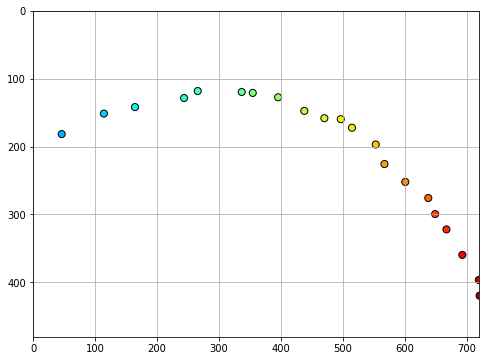

In [702]:
plt.figure(figsize=(8, 6))
colors = np.arange(0, x1.shape[1])
plt.scatter(x1[0], x1[1], c=colors, s = 50, linewidths=1, edgecolor='black', cmap='jet')
plt.ylim(480, 0)
plt.xlim(0, 720)
plt.grid(True)

### Display Camera 2

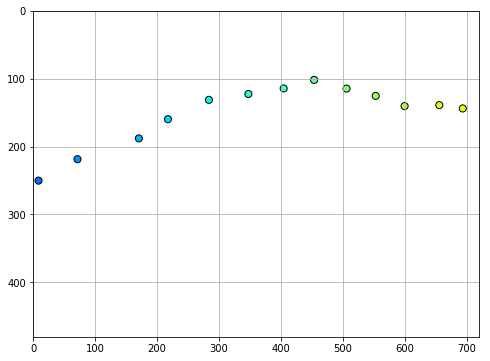

In [703]:
plt.figure(figsize=(8, 6))
colors = np.arange(0, x2.shape[1])
plt.scatter(x2[0], x2[1], c=colors, s = 50, linewidths=1, edgecolor='black', cmap='jet')
plt.ylim(480, 0)
plt.xlim(0, 720)
plt.grid(True)

# Simulation

In [704]:
mu_predict = []
mu_update = []

sim = EKF(F, g, h, H, Rw, Rv, 9810)
y = np.array(([x1[0,9]], [x1[1,9]], [x2[0,9]], [x2[1,9]]))
mu_hat, sigma_hat = sim.initialise(K, Rt, y)
mu_update.append(mu_hat)

for i in range(10, 19):
    y = np.array(([x1[0,i]], [x1[1,i]], [x2[0,i]], [x2[1,i]]))
    mu_bar, sigma_bar = sim.predict(mu_hat, sigma_hat)
    mu_predict.append(mu_bar)
    mu_hat, sigma_hat = sim.measurement_update(mu_bar, sigma_bar, y)
    mu_update.append(mu_hat)
mu_bar, sigma_bar = sim.predict(mu_hat, sigma_hat)
mu_predict.append(mu_bar)

# Result Plotting

In [705]:
def plot_xy(x_predict, y_predict, x_update, y_update, x_true, y_true, x_fit, y_fit, file):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(111)

    ax.plot(x_predict, y_predict, c='blue')
    ax.plot(x_update, y_update, c='green')
    ax.plot(x_true, y_true, c='red')
    ax.plot(x_fit, y_fit, c='orange')
    
    colors = np.arange(0, len(x_predict))
    ax.scatter(x_predict, y_predict, c=colors, marker='x', s = 150, cmap='jet')
    colors = np.arange(0, len(x_update))
    ax.scatter(x_update, y_update, c=colors, marker='D', s = 30, linewidths=1, edgecolor='black', cmap='jet')
    colors = np.arange(0, len(x_true))
    ax.scatter(x_true, y_true, c=colors, s = 50, linewidths=1, edgecolor='black', cmap='jet')
    colors = np.arange(0, len(x_fit))
    ax.scatter(x_fit, y_fit, c=colors, marker='*', s = 100, linewidths=1, edgecolor='black', cmap='jet')

    ax.set_title('EKF trajectory estimation in X-Y plane for dataset \"%s\"\n' %file, fontsize=18)
    ax.set_xlabel('X [mm]', fontsize=16)
    ax.set_ylabel('Y [mm]', fontsize=16)
    
    crosses = mlines.Line2D([], [], color='blue', marker='x', markersize=10, label='Prediction Estimate')
    diamonds = mlines.Line2D([], [], color='green', marker='D', markersize=7, label='Measurement Update Estimate')
    circles = mlines.Line2D([], [], color='red', marker='o', markersize=7, label='True Location')
    stars = mlines.Line2D([], [], color='orange', marker='*', markersize=7, label='Best Fit')
    ax.legend(handles=[crosses, diamonds, circles, stars], loc='lower left', bbox_to_anchor=(0.27, 0), fontsize= 16)
    
    ax.set_xlim(np.min(x_true)-100, np.max(x_true)+100)
    ax.set_ylim(np.min(y_true)-50, np.max(y_true)+50)
    ax.grid(True)
    
    plt.gca().invert_yaxis()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.show()
    
    fig.savefig("Results\Graphs\%s_XY.pdf" %file, bbox_inches='tight')

In [706]:
def plot_xz(x_predict, z_predict, x_update, z_update, x_true, z_true, x_fit, z_fit, file):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(111)

    ax.plot(x_predict, z_predict, c='blue')
    ax.plot(x_update, z_update, c='green')
    ax.plot(x_true, z_true, c='red')
    ax.plot(x_fit, z_fit, c='orange')
    
    colors = np.arange(0, len(x_predict))
    ax.scatter(x_predict, z_predict, c=colors, marker='x', s = 150, cmap='jet')
    colors = np.arange(0, len(x_update))
    ax.scatter(x_update, z_update, c=colors, marker='D', s = 30, linewidths=1, edgecolor='black', cmap='jet')
    colors = np.arange(0, len(x_true))
    ax.scatter(x_true, z_true, c=colors, s = 50, linewidths=1, edgecolor='black', cmap='jet')
    colors = np.arange(0, len(x_fit))
    ax.scatter(x_fit, z_fit, c=colors, marker='*', s = 100, linewidths=1, edgecolor='black', cmap='jet')
    
    ax.set_title('EKF trajectory estimation in X-Z plane for dataset \"%s\"\n' %file, fontsize=18)
    ax.set_xlabel('X [mm]', fontsize=16)
    ax.set_ylabel('Z [mm]', fontsize=16)
    
    crosses = mlines.Line2D([], [], color='blue', marker='x', markersize=10, label='Prediction Estimate')
    diamonds = mlines.Line2D([], [], color='green', marker='D', markersize=7, label='Measurement Update Estimate')
    circles = mlines.Line2D([], [], color='red', marker='o', markersize=7, label='True Location')
    stars = mlines.Line2D([], [], color='orange', marker='*', markersize=7, label='Best Fit')
    ax.legend(handles=[crosses, diamonds, circles, stars], loc='lower left', bbox_to_anchor=(0.27, 0), fontsize= 16)
    
    ax.set_xlim(np.min(x_true)-100, np.max(x_true)+100)
    ax.set_ylim(np.min(z_true)-200, np.max(z_true)+200)
    ax.grid(True)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.show()
    
    fig.savefig("Results\Graphs\%s_XZ.pdf" %file, bbox_inches='tight')

In [707]:
def plot_3d(x_predict, y_predict, z_predict, x_update, y_update, z_update, x_true, y_true, z_true, x_fit, y_fit, z_fit, file):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    #3D points
    ax.plot(np.array(x_predict), np.array(z_predict), np.array(y_predict), zdir='z', c='blue')
    ax.plot(np.array(x_update), np.array(z_update), np.array(y_update), zdir='z', c='green')
    ax.plot(np.array(x_true), np.array(z_true), np.array(y_true), zdir='z', c='red')
    ax.plot(np.array(x_fit), np.array(z_fit), np.array(y_fit), zdir='z', c='orange')
    colors = np.arange(0, len(z_predict))
    ax.scatter(np.array(x_predict), np.array(z_predict), np.array(y_predict), zdir='z', c=colors, marker='x', s = 150, cmap='jet')
    colors = np.arange(0, len(z_update))
    ax.scatter(np.array(x_update), np.array(z_update), np.array(y_update), zdir='z', c=colors,
               marker='D', s = 30, linewidths=1, edgecolor='black', cmap='jet')
    colors = np.arange(0, len(z_true))
    ax.scatter(np.array(x_true), np.array(z_true), np.array(y_true), zdir='z', c=colors,
               s = 50, linewidths=1, edgecolor='black', cmap='jet')
    colors = np.arange(0, len(z_fit))
    ax.scatter(np.array(x_fit), np.array(z_fit), np.array(y_fit), zdir='z', c=colors,
               marker='*', s = 100, linewidths=1, edgecolor='black', cmap='jet')

    #2D projections
    y = np.full(len(y_predict), np.max(y_true)+150)

    ax.plot(np.array(x_predict), np.array(z_predict), y, zdir='z', c = 'black')
    colors = np.arange(0, len(z_predict))
    colors = colors[::-1]
    ax.scatter(np.array(x_predict), np.array(z_predict), y, zdir='z', c=colors, marker='x', s = 150, cmap=plt.cm.Greys)
    
    y = np.full(len(y_update), np.max(y_true)+150)
    
    ax.plot(np.array(x_update), np.array(z_update), y, zdir='z', c = 'black')
    colors = np.arange(0, len(z_update))
    colors = colors[::-1]
    ax.scatter(np.array(x_update), np.array(z_update), y, zdir='z', c=colors,
               marker='D', s = 30, cmap=plt.cm.Greys, linewidths=1, edgecolor='black')
    
    y = np.full(len(y_true), np.max(y_true)+150)
    
    ax.plot(np.array(x_true), np.array(z_true), y, zdir='z', c = 'black')
    colors = np.arange(0, len(z_true))
    colors = colors[::-1]
    ax.scatter(np.array(x_true), np.array(z_true), y, zdir='z', c=colors,
               s = 30, cmap=plt.cm.Greys, linewidths=1, edgecolor='black')
    
    y = np.full(len(y_fit), np.max(y_fit)+150)
    
    ax.plot(np.array(x_fit), np.array(z_fit), y, zdir='z', c = 'black')
    colors = np.arange(0, len(z_fit))
    colors = colors[::-1]
    ax.scatter(np.array(x_fit), np.array(z_fit), y, zdir='z', c=colors,
               marker='*', s = 100, cmap=plt.cm.Greys, linewidths=1, edgecolor='black')

    z = np.full(len(z_predict), np.max(z_true)+300)

    ax.plot(np.array(x_predict), z, np.array(y_predict), zdir='z', c = 'black')
    colors = np.arange(0, len(z_predict))
    colors = colors[::-1]
    ax.scatter(np.array(x_predict), z, np.array(y_predict), zdir='z', c=colors, marker='x', s = 150, cmap=plt.cm.Greys)
    
    z = np.full(len(z_update), np.max(z_true)+300)
    
    ax.plot(np.array(x_update), z, np.array(y_update), zdir='z', c = 'black')
    colors = np.arange(0, len(z_update))
    colors = colors[::-1]
    ax.scatter(np.array(x_update), z, np.array(y_update), zdir='z', c=colors,
               marker='D', s = 30, cmap=plt.cm.Greys, linewidths=1, edgecolor='black')
    
    z = np.full(len(z_true), np.max(z_true)+300)
    
    ax.plot(np.array(x_true), z, np.array(y_true), zdir='z', c = 'black')
    colors = np.arange(0, len(z_update))
    colors = colors[::-1]
    ax.scatter(np.array(x_true), z, np.array(y_true), zdir='z', c=colors,
               s = 30, cmap=plt.cm.Greys, linewidths=1, edgecolor='black')
    
    z = np.full(len(z_fit), np.max(z_fit)+300)
    
    ax.plot(np.array(x_fit), z, np.array(y_fit), zdir='z', c = 'black')
    colors = np.arange(0, len(z_fit))
    colors = colors[::-1]
    ax.scatter(np.array(x_fit), z, np.array(y_fit), zdir='z', c=colors,
               marker='*', s = 100, cmap=plt.cm.Greys, linewidths=1, edgecolor='black')

    ax.set_title('EKF trajectory estimation in 3-D space for dataset \"%s\"\n' %file, fontsize=18)
    ax.set_xlim(np.min(x_true)-50, np.max(x_true)+50)
    ax.set_ylim(np.min(z_true)-200, np.max(z_true)+300)
    ax.set_zlim(np.min(y_true)-50, np.max(y_true)+150)
    
    crosses = mlines.Line2D([], [], color='blue', marker='x', markersize=10, label='Prediction Estimate')
    diamonds = mlines.Line2D([], [], color='green', marker='D', markersize=7, label='Measurement Update Estimate')
    circles = mlines.Line2D([], [], color='red', marker='o', markersize=7, label='True Location')
    stars = mlines.Line2D([], [], color='orange', marker='*', markersize=10, label='Best Fit')
    ax.legend(handles=[crosses, diamonds, circles, stars], loc='upper left', bbox_to_anchor=(0.27, 0), fontsize= 16)
    
    ax.set_xlabel('X [mm]', fontsize=16)
    ax.set_ylabel('Z [mm]', fontsize=16)
    ax.set_zlabel('Y [mm]', fontsize=16)

    plt.gca().invert_zaxis()
    
    plt.show()
    
    fig.savefig("Results\Graphs\%s_3D.pdf" %file, bbox_inches='tight')

# Results

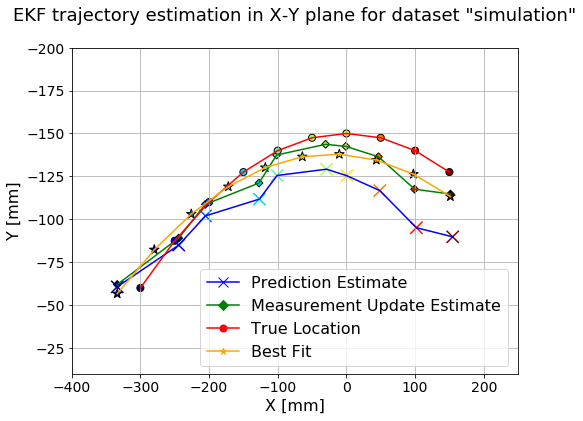

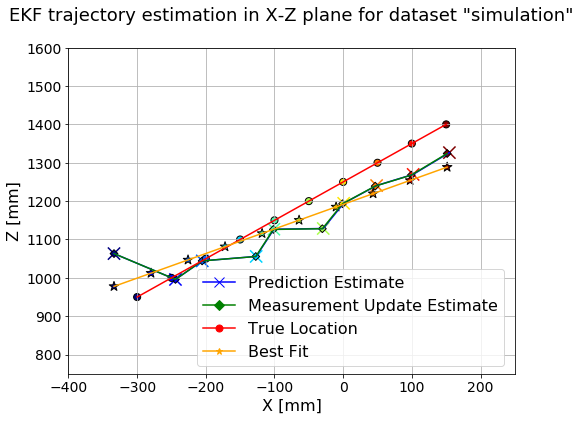

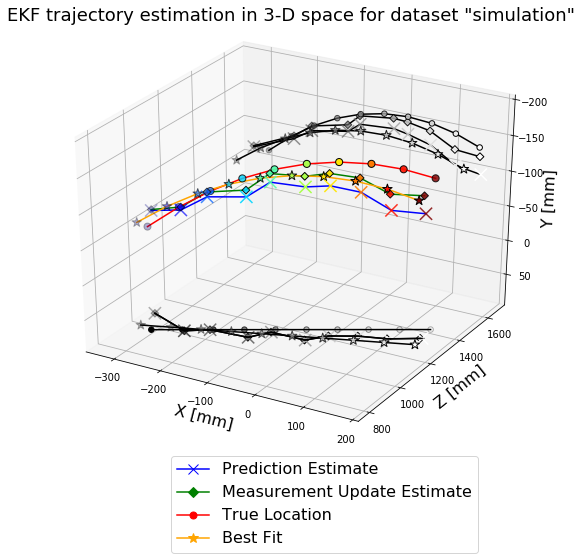

In [708]:
file = 'simulation'

x_predict, y_predict, z_predict, x_update, y_update, z_update, x_true, y_true, z_true = [], [], [], [], [], [], [], [], []
for i in range(len(mu_update)):
    x_predict.append(mu_predict[i][0,0])
    y_predict.append(mu_predict[i][1,0])
    z_predict.append(mu_predict[i][2,0])
    x_update.append(mu_update[i][0,0])
    y_update.append(mu_update[i][1,0])
    z_update.append(mu_update[i][2,0])
    x_true.append(points_3d[0,i+9])
    y_true.append(points_3d[1,i+9])
    z_true.append(points_3d[2,i+9])

def f(x, A, B):
    return A*x + B
A, B = curve_fit(f, x_update, z_update)[0]
x_fit = np.linspace(np.min(x_update), np.max(x_update), len(mu_update))
z_fit = A*x_fit + B

def f(x, A, B, C):
    return A*x**2 + B*x + C
A, B, C = curve_fit(f, x_update, y_update)[0]
y_fit = A*x_fit**2 + B*x_fit + C
    
plot_xy(x_predict, y_predict, x_update, y_update, x_true, y_true, x_fit, y_fit, file)
plot_xz(x_predict, z_predict, x_update, z_update, x_true, z_true, x_fit, z_fit, file)
plot_3d(x_predict, y_predict, z_predict, x_update, y_update, z_update, x_true, y_true, z_true, x_fit, y_fit, z_fit, file)

In [710]:
points_predict, points_update, points_true, points_fit = [], [], [], []
for i in range(len(x_true)):
    points_predict.append(np.array(([x_predict[i]], [y_predict[i]], [z_predict[i]])))
    points_update.append(np.array(([x_update[i]], [y_update[i]], [z_update[i]])))
    points_true.append(np.array(([x_true[i]], [y_true[i]], [z_true[i]])))
    points_fit.append(np.array(([x_fit[i]], [y_fit[i]], [z_fit[i]])))

In [714]:
dist_predict, dist_update, dist_fit = [], [], []
for i in range(len(points_true)):
    dist_predict.append(numpy.linalg.norm(points_predict[i] - points_true[i]))
    dist_update.append(numpy.linalg.norm(points_update[i] - points_true[i]))
    dist_fit.append(numpy.linalg.norm(points_fit[i] - points_true[i]))
print('mean predition error:\t %f mm'%np.mean(dist_predict))
print('max predition error:\t %f mm'%np.max(dist_predict))
print('mean update error:\t %f mm'%np.mean(dist_update))
print('max update error:\t %f mm'%np.max(dist_update))
print('mean fit error:\t\t %f mm'%np.mean(dist_fit))
print('max fit error:\t\t %f mm'%np.max(dist_fit))

mean predition error:	 59.582389 mm
max predition error:	 118.184369 mm
mean update error:	 56.377326 mm
max update error:	 118.199913 mm
mean fit error:		 58.397890 mm
max fit error:		 112.337510 mm


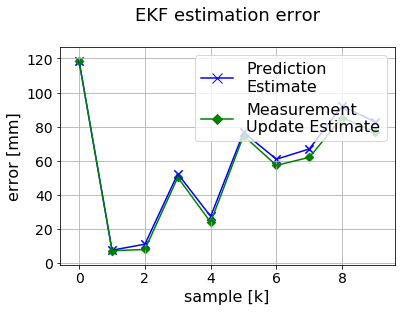

In [712]:
x = np.arange(0, len(points_true))
plt.plot(x, dist_predict, c='blue')
plt.plot(x, dist_update, c ='green')
plt.scatter(x, dist_predict, c='blue', marker ='x', s=70)
plt.scatter(x, dist_update, c ='green', marker ='D')
plt.title('EKF estimation error\n', fontsize=18)
crosses = mlines.Line2D([], [], color='blue', marker='x', markersize=10, label='Prediction\nEstimate')
diamonds = mlines.Line2D([], [], color='green', marker='D', markersize=7, label='Measurement\nUpdate Estimate')
plt.legend(handles=[crosses, diamonds], loc='upper right', bbox_to_anchor=(1, 1), fontsize= 16)
plt.xlabel('sample [k]', fontsize=16)
plt.ylabel('error [mm]', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

plt.savefig("Results\Graphs\Simulation_Error.pdf", bbox_inches='tight')

# Error testing

In [718]:
mean_pred = []
mean_up = []
mean_fit = []
max_pred = []
max_up = []
max_fit = []

for j in range(100):
    points_3d = generate_3d_path()
    x1, x2 = camera_points_noisy(points_3d, 8)
    mu_predict = []
    mu_update = []

    sim = EKF(F, g, h, H, Rw, Rv, 9810)
    y = np.array(([x1[0,9]], [x1[1,9]], [x2[0,9]], [x2[1,9]]))
    mu_hat, sigma_hat = sim.initialise(K, Rt, y)
    mu_update.append(mu_hat)

    for i in range(10, 19):
        y = np.array(([x1[0,i]], [x1[1,i]], [x2[0,i]], [x2[1,i]]))
        mu_bar, sigma_bar = sim.predict(mu_hat, sigma_hat)
        mu_predict.append(mu_bar)
        mu_hat, sigma_hat = sim.measurement_update(mu_bar, sigma_bar, y)
        mu_update.append(mu_hat)
    mu_bar, sigma_bar = sim.predict(mu_hat, sigma_hat)
    mu_predict.append(mu_bar)

    file = 'simulation'

    x_predict, y_predict, z_predict, x_update, y_update, z_update, x_true, y_true, z_true = [], [], [], [], [], [], [], [], []
    for i in range(len(mu_update)):
        x_predict.append(mu_predict[i][0,0])
        y_predict.append(mu_predict[i][1,0])
        z_predict.append(mu_predict[i][2,0])
        x_update.append(mu_update[i][0,0])
        y_update.append(mu_update[i][1,0])
        z_update.append(mu_update[i][2,0])
        x_true.append(points_3d[0,i+9])
        y_true.append(points_3d[1,i+9])
        z_true.append(points_3d[2,i+9])
        
    def f(x, A, B):
        return A*x + B
    A, B = curve_fit(f, x_update, z_update)[0]
    x_fit = np.linspace(np.min(x_update), np.max(x_update), len(mu_update))
    z_fit = A*x_fit + B

    def f(x, A, B, C):
        return A*x**2 + B*x + C
    A, B, C = curve_fit(f, x_update, y_update)[0]
    y_fit = A*x_fit**2 + B*x_fit + C

    points_predict, points_update, points_true, points_fit = [], [], [], []
    for i in range(len(x_true)):
        points_predict.append(np.array(([x_predict[i]], [y_predict[i]], [z_predict[i]])))
        points_update.append(np.array(([x_update[i]], [y_update[i]], [z_update[i]])))
        points_true.append(np.array(([x_true[i]], [y_true[i]], [z_true[i]])))
        points_fit.append(np.array(([x_fit[i]], [y_fit[i]], [z_fit[i]])))

    dist_predict, dist_update, dist_fit = [], [], []
    for i in range(len(points_true)):
        dist_predict.append(numpy.linalg.norm(points_predict[i] - points_true[i]))
        dist_update.append(numpy.linalg.norm(points_update[i] - points_true[i]))
        dist_fit.append(numpy.linalg.norm(points_fit[i] - points_true[i]))

    mean_pred.append(np.mean(dist_predict))
    max_pred.append(np.max(dist_predict))
    mean_up.append(np.mean(dist_update))
    max_up.append(np.max(dist_update))
    mean_fit.append(np.mean(dist_fit))
    max_fit.append(np.max(dist_fit))
    print(j)
    
print('mean predition error for 100 runs:\t %f mm'%np.mean(mean_pred))
print('max predition error for 100 runs:\t %f mm'%np.max(max_pred))
print('mean update error for 100 runs:\t %f mm'%np.mean(mean_up))
print('max update error for 100 runs:\t %f mm'%np.max(max_up))
print('mean fit error for 100 runs:\t\t %f mm'%np.mean(mean_fit))
print('max fit error for 100 runs:\t\t %f mm'%np.max(max_fit))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
mean predition error for 100 runs:	 50.414722 mm
max predition error for 100 runs:	 191.447906 mm
mean update error for 100 runs:	 47.144799 mm
max update error for 100 runs:	 191.646009 mm
mean fit error for 100 runs:		 47.037874 mm
max fit error for 100 runs:		 164.844990 mm
